<a href="https://colab.research.google.com/github/sadmantamzid/Quantum-Reinforcement/blob/main/g9_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing librarries from Quandela **

In [ ]:
!pip install perceval-quandela

In [ ]:
from __future__ import annotations

import math

from ipywidgets import FloatProgress
from IPython.display import display

import perceval as pcvl
import numpy as np
import matplotlib.pyplot as plt
from perceval.components.unitary_components import Unitary, BS, PS
from perceval.rendering import DisplayConfig, SymbSkin

**Classical Q‑learning for the 4×4 maze**

In [ ]:
import numpy as np
import random

# Grid size
n_rows = 4
n_cols = 4
n_states = n_rows * n_cols   # 16 states: 0..15

# Actions: 0=up, 1=right, 2=down, 3=left
n_actions = 4

# Hyperparameters
alpha = 0.1      # learning rate
gamma = 0.95     # discount factor
epsilon = 0.2    # exploration rate (epsilon-greedy)

# Rewards
step_penalty = -1.0   # small negative reward each move
goal_reward = 10.0    # reward at the goal

goal_state = n_states - 1   # bottom-right cell: 15

# Initialize Q-table with zeros
Q = np.zeros((n_states, n_actions))


**Helpers to convert between state index and (row, col)**

In [ ]:
def state_to_pos(s):
    """Convert state index to (row, col)."""
    return divmod(s, n_cols)   # (row, col)

def pos_to_state(row, col):
    """Convert (row, col) back to state index."""
    return row * n_cols + col


**Step function: simulate one move**

In [ ]:
def step(state, action):
    """
    Take one step in the grid.
    Returns: next_state, reward, done
    """
    row, col = state_to_pos(state)

    # Move according to action, but keep inside the grid
    if action == 0:   # up
        row = max(row - 1, 0)
    elif action == 1: # right
        col = min(col + 1, n_cols - 1)
    elif action == 2: # down
        row = min(row + 1, n_rows - 1)
    elif action == 3: # left
        col = max(col - 1, 0)

    next_state = pos_to_state(row, col)

    # Reward logic
    if next_state == goal_state:
        reward = goal_reward
        done = True
    else:
        reward = step_penalty
        done = False

    return next_state, reward, done


**We have taken the Choosing Policy as epsilon‑greedy action choice**

In [ ]:
def choose_action(state, epsilon):
    """
    Epsilon-greedy policy: with probability epsilon choose random action,
    otherwise choose the action with highest Q-value.
    """
    if random.random() < epsilon:
        # Explore
        return random.randint(0, n_actions - 1)
    else:
        # Exploit
        return int(np.argmax(Q[state]))


**Training loop: many episodes, We run 2000 episodes loop**

In [ ]:
n_episodes = 2000
max_steps_per_episode = 50

for episode in range(n_episodes):
    state = 0  # start at top-left
    for step_i in range(max_steps_per_episode):
        # 1. Choose action
        action = choose_action(state, epsilon)

        # 2. Apply action, observe next state and reward
        next_state, reward, done = step(state, action)

        # 3. Q-learning update
        best_next_action = np.argmax(Q[next_state])
        td_target = reward + gamma * Q[next_state, best_next_action]
        td_error = td_target - Q[state, action]
        Q[state, action] += alpha * td_error

        # 4. Move to next state
        state = next_state

        # 5. If episode finished, break
        if done:
            break

    # Optional: slowly reduce epsilon to exploit more later
    if epsilon > 0.01:
        epsilon *= 0.999


**After training, we can extract the “best move” in each cell.**

In [ ]:
action_symbols = {0: 'U', 1: 'R', 2: 'D', 3: 'L'}

def print_policy():
    for r in range(n_rows):
        row_symbols = []
        for c in range(n_cols):
            s = pos_to_state(r, c)
            if s == goal_state:
                row_symbols.append('G')  # Goal
            else:
                best_a = int(np.argmax(Q[s]))
                row_symbols.append(action_symbols[best_a])
        print(' '.join(row_symbols))

print_policy()


D D D D
R D D D
R R R D
R R R G


In [ ]:
def mzi(name:str, theta:float | pcvl.Parameter, phi:float | pcvl.Parameter, theta_2:float | pcvl.Parameter) -> pcvl.Circuit:
    # For the mzi to be in the right shape:
    #   theta_2 should be set to '- pi/2 - theta/2'
    #   however we cannot pass a symbolic expression to the input of PS
    #   so we need to define a third angle theta_2 that we will set to '- pi/2 - theta/2' later on
    return (
        pcvl.Circuit(2, name=name)
        .add(0, BS())
        .add(0, PS(theta))
        .add(0, BS())
        .add(0, PS(phi))
        .add(0, PS(theta_2))
        .add(1, PS(theta_2))
    )


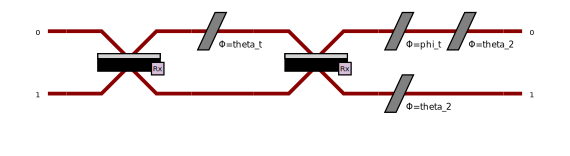

In [ ]:

theta_t = pcvl.P("theta_t")
phi_t = pcvl.P("phi_t")
theta_2 = pcvl.P("theta_2")

pcvl.pdisplay(mzi("test", theta_t, phi_t, theta_2))

In [ ]:
hadamard = mzi("H", math.pi/2, 0, -math.pi/2 - math.pi/4)

pcvl.pdisplay(hadamard.U)

<IPython.core.display.Math object>

In [ ]:
theta_prep = pcvl.P("theta_prep") # We will set it to pi - 2*xi later
theta2_prep = pcvl.P("theta2_prep") # We will set it to -pi/2 - pi/2 + xi = -pi + xi later as we cannot pass symbolic expression to the function mzi
state_prep = mzi("U_p", theta_prep, 0, theta2_prep)

In [ ]:
env = mzi("U_E", -2 * math.pi, 0, -math.pi/2 + math.pi)

pcvl.pdisplay(env.U)

<IPython.core.display.Math object>

In [ ]:
theta_ref = pcvl.P("theta_ref") # We will set it to pi - 4*xi later
theta2_ref = pcvl.P("theta2_ref") # We will set it to -pi/2 - pi/2 + 2xi = -pi + 2xi later as we cannot pass symbolic expression to the function mzi
ref = mzi("U_ref", theta_ref, 0, theta2_ref)

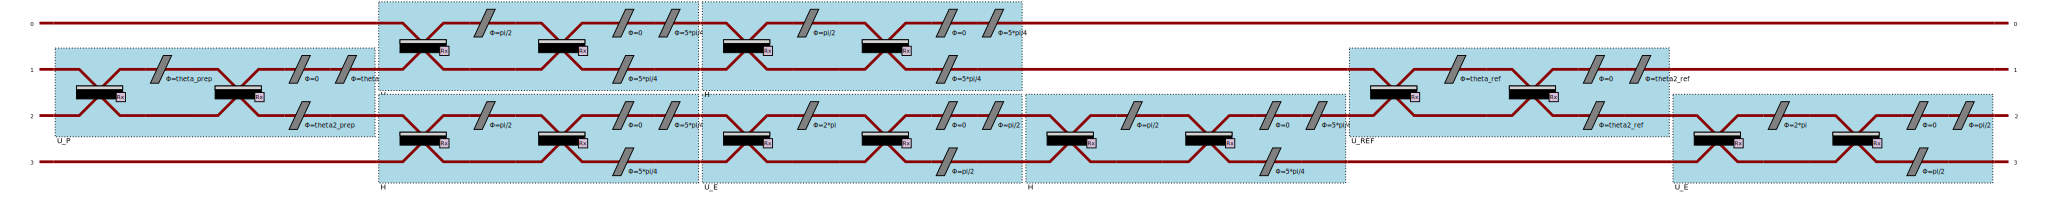

In [ ]:
quantum_circuit = pcvl.Circuit(4)
quantum_circuit.add(1, state_prep).add(0, hadamard).add(2, hadamard).add(2, env).add(0, hadamard).add(2, hadamard).add(1, ref) #circuit for quantum strategy
quantum_circuit.add(2,env) #appending directly the classical round (without preparation) at the end
pcvl.pdisplay(quantum_circuit, recursive=True)

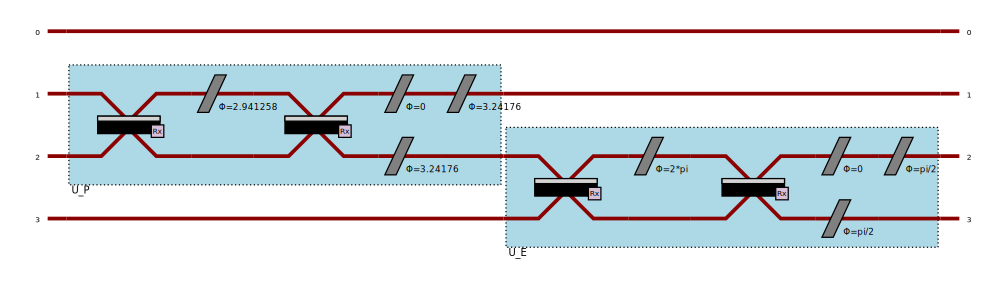

In [ ]:
classical_circuit = pcvl.Circuit(4)
classical_circuit.add(1, state_prep).add(2, env) # circuit for classical strategy
pcvl.pdisplay(classical_circuit, recursive=True)

In [ ]:
# Simulation parameters
N_AGENTS = 100 #number of agents that we simulate and average over
N_EPOCH = 1000
H_0 = 99
H_1 = 1
EPS0 = H_1 / (H_0+H_1)

In [ ]:
def get_reward(circuit: pcvl.Circuit) -> bool:
    proc = pcvl.Processor("SLOS", circuit)
    proc.with_input(pcvl.BasicState([0, 1, 0, 0]))
    sampler = pcvl.algorithm.Sampler(proc)
    samples = sampler.samples(1)

    # Take a random sample and check if it's the rewarded state or not
    return samples["results"][0] == pcvl.BasicState([0, 0, 0, 1])

In [ ]:
eta_classical = []

# Percentage bar
f = FloatProgress(min=0, max=N_AGENTS)
display(f)

for agent in range(N_AGENTS): #Loop and average over all agents
    f.value = agent
    # Initialize initial score
    h_0 = H_0
    h_1 = H_1
    eps = h_1 / (h_0 + h_1)

    # Initialize circuit with initial probability and corresponding angles
    xi = math.asin(eps**0.5)

    theta1 = math.pi - 2*xi
    theta_prep.set_value(theta1)
    theta2_prep.set_value(-math.pi/2 - theta1/2)

    # Arrays of epsilon
    eps_array = []
    for i in range(N_EPOCH):
        if get_reward(classical_circuit): #update policy if output state corresponds to a rewarded state
            h_1 = h_1 + 2
            eps = h_1 / (h_0 + h_1)
            xi = math.asin(eps**0.5)
            theta1 = math.pi - 2*xi
            theta_prep.set_value(theta1)
            theta2_prep.set_value(-math.pi/2 - theta1/2)
            eps_array.append(1)
        else:
            eps_array.append(0)

    eta_classical.append(eps_array)

eta_classical = np.array(eta_classical)
f.value = N_AGENTS

FloatProgress(value=0.0)

<>:3: SyntaxWarning: invalid escape sequence '\e'
<>:3: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipython-input-3262317766.py:3: SyntaxWarning: invalid escape sequence '\e'
  plt.ylabel("$\eta$")


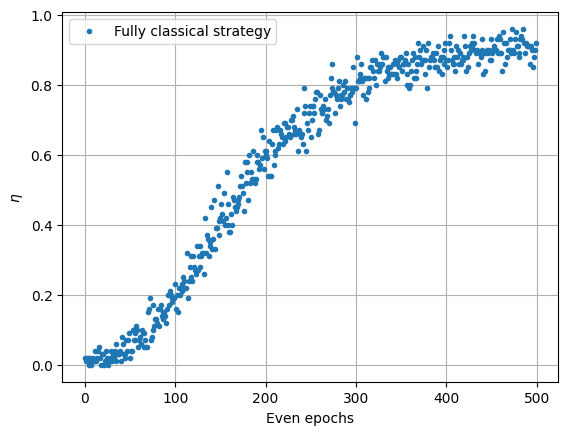

In [ ]:
plt.plot(np.mean(eta_classical, axis=0)[::2], ".", label="Fully classical strategy")
plt.xlabel("Even epochs")
plt.ylabel("$\eta$")
plt.legend()
plt.grid()

In [ ]:
eta_quantum = []

# Percentage bar
f = FloatProgress(min=0, max=N_AGENTS)
display(f)

for agent in range(N_AGENTS):
    f.value = agent
    # Initialize initial scores
    h_0 = H_0
    h_1 = H_1
    eps = h_1 / (h_0 + h_1)

    # Initialize circuit with initial probability
    xi = math.asin(eps**0.5)

    theta1 = math.pi - 2*xi
    theta_prep.set_value(theta1)
    theta2_prep.set_value(-math.pi/2 - theta1/2)

    theta2 = math.pi - 4*xi
    theta_ref.set_value(theta2)
    theta2_ref.set_value(-math.pi/2 - theta2/2)

    # Arrays of epsilon
    eps_array = []
    for i in range(N_EPOCH//2):
        if get_reward(quantum_circuit):
            h_1 = h_1 + 2
            eps = h_1 / (h_0 + h_1)
            xi = math.asin(eps**0.5)

            theta1 = math.pi - 2*xi
            theta_prep.set_value(theta1)
            theta2_prep.set_value(-math.pi/2 - theta1/2)

            theta2 = math.pi - 4*xi
            theta_ref.set_value(theta2)
            theta2_ref.set_value(-math.pi/2 - theta2/2)

            eps_array.append(0.5)
            eps_array.append(0.5)
        else:
            eps_array.append(0)
            eps_array.append(0)

    eta_quantum.append(eps_array)

eta_quantum = np.array(eta_quantum)
f.value=N_AGENTS

FloatProgress(value=0.0)

<>:3: SyntaxWarning: invalid escape sequence '\e'
<>:3: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipython-input-1938968234.py:3: SyntaxWarning: invalid escape sequence '\e'
  plt.ylabel("$\eta$")


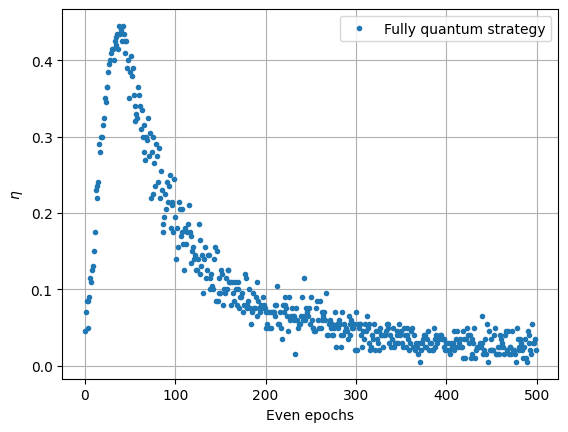

In [ ]:
plt.plot(np.mean(eta_quantum, axis=0)[::2], ".", label="Fully quantum strategy")
plt.xlabel("Even epochs")
plt.ylabel("$\eta$")
plt.legend()
plt.grid()

In [ ]:
QL = 0.37
eta_classical_quantum = []

# Percentage bar
f = FloatProgress(min=0, max=N_AGENTS)
display(f)

for agent in range(N_AGENTS):
    f.value = agent
    # Initialize initial scores
    h_0 = H_0
    h_1 = H_1
    eps = h_1 / (h_0 + h_1)

    # Initialize circuit with initial probability
    xi = math.asin(eps**0.5)

    theta1 = math.pi - 2*xi
    theta_prep.set_value(theta1)
    theta2_prep.set_value(-math.pi/2 - theta1/2)

    theta2 = math.pi - 4*xi
    theta_ref.set_value(theta2)
    theta2_ref.set_value(-math.pi/2 - theta2/2)

    # Arrays of epsilon
    eps_array = []
    i = 0
    while i < N_EPOCH:
        if eps < QL:
            # Perform a quantum round
            if get_reward(quantum_circuit):
                h_1 = h_1 + 2
                eps = h_1 / (h_0 + h_1)
                xi = math.asin(eps**0.5)
                theta1 = math.pi - 2*xi
                theta_prep.set_value(theta1)
                theta2_prep.set_value(-math.pi/2 - theta1/2)

                theta2 = math.pi - 4*xi
                theta_ref.set_value(theta2)
                theta2_ref.set_value(-math.pi/2 - theta2/2)
                eps_array.append(0.5)
                eps_array.append(0.5)
            else:
                eps_array.append(0)
                eps_array.append(0)

            # Update epoch by 2
            i = i + 2
        else:
            # Perform a classical round
            if get_reward(classical_circuit):
                h_1 = h_1 + 2
                eps = h_1 / (h_0 + h_1)
                xi = math.asin(eps**0.5)
                theta1 = math.pi - 2*xi
                theta_prep.set_value(theta1)
                theta2_prep.set_value(-math.pi/2 - theta1/2)

                eps_array.append(1)
            else:
                eps_array.append(0)
            # Update epoch by 1
            i = i + 1

    eta_classical_quantum.append(eps_array)

eta_classical_quantum = np.array(eta_classical_quantum)
f.value=N_AGENTS

FloatProgress(value=0.0)

<>:5: SyntaxWarning: invalid escape sequence '\e'
<>:5: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipython-input-2325843546.py:5: SyntaxWarning: invalid escape sequence '\e'
  plt.ylabel("$\eta$")


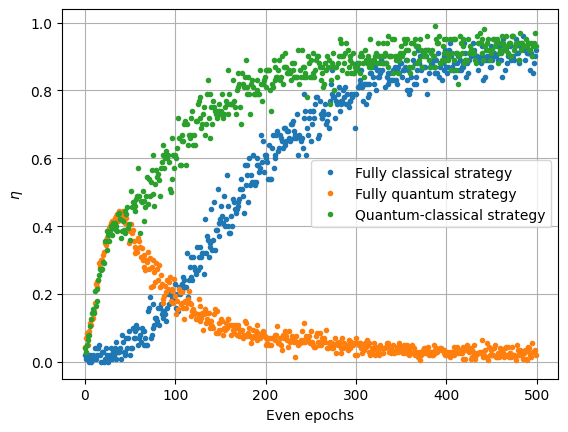

In [ ]:
plt.plot(np.mean(eta_classical, axis=0)[::2], ".", label="Fully classical strategy")
plt.plot(np.mean(eta_quantum, axis=0)[::2], ".", label="Fully quantum strategy")
plt.plot(np.mean(eta_classical_quantum,axis=0,)[::2],".",label="Quantum-classical strategy",)
plt.xlabel("Even epochs")
plt.ylabel("$\eta$")
plt.legend()
plt.grid()

In [ ]:
n_rows = 4
n_cols = 4
n_states = n_rows * n_cols
n_actions = 4  # 0=up, 1=right, 2=down, 3=left

NEGATIVE_STATES = {2, 5, 11}
GOAL_STATE = 15
START_STATE = 0

step_penalty = -1.0
goal_reward = 10.0
negative_reward = -10.0

def state_to_pos(s):
    return divmod(s, n_cols)

def pos_to_state(r, c):
    return r * n_cols + c

def step_env(state, action):
    """4x4 grid dynamics with negative and goal states."""
    r, c = state_to_pos(state)
    if action == 0:      # up
        r = max(r - 1, 0)
    elif action == 1:    # right
        c = min(c + 1, n_cols - 1)
    elif action == 2:    # down
        r = min(r + 1, n_rows - 1)
    elif action == 3:    # left
        c = max(c - 1, 0)
    next_state = pos_to_state(r, c)

    if next_state == GOAL_STATE:
        return next_state, goal_reward, True
    if next_state in NEGATIVE_STATES:
        return next_state, negative_reward, True
    return next_state, step_penalty, False

# ===== 2. Helper: moving average =====

def moving_avg(x, w=50):
    if len(x) < w:
        return x.copy()
    return np.convolve(x, np.ones(w) / w, mode='valid')


In [ ]:
def run_classical_q(alpha=0.1, gamma=0.95,
                    epsilon=0.2, episodes=2000, max_steps=50):
    Q = np.zeros((n_states, n_actions))
    episode_returns = []
    episode_lengths = []

    for ep in range(episodes):
        s = START_STATE
        total_r = 0.0

        for t in range(max_steps):
            # epsilon-greedy
            if random.random() < epsilon:
                a = random.randint(0, n_actions - 1)
            else:
                a = int(np.argmax(Q[s]))

            s_next, r, done = step_env(s, a)
            total_r += r

            # Q-learning update
            best_next = np.argmax(Q[s_next])
            td_target = r + gamma * Q[s_next, best_next]
            td_error = td_target - Q[s, a]
            Q[s, a] += alpha * td_error

            s = s_next
            if done:
                break

        episode_returns.append(total_r)
        episode_lengths.append(t + 1)

        # mild epsilon decay
        if epsilon > 0.01:
            epsilon *= 0.999

    return Q, np.array(episode_returns), np.array(episode_lengths)


In [ ]:
def run_quantum_naive(alpha=0.1, gamma=0.95, eta=0.1,
                      episodes=2000, max_steps=50):
    Q = np.zeros((n_states, n_actions))
    amplitudes = np.ones((n_states, n_actions)) / np.sqrt(n_actions)

    episode_returns = []
    episode_lengths = []

    for ep in range(episodes):
        s = START_STATE
        total_r = 0.0

        for t in range(max_steps):
            # sample action from |a|^2 distribution
            probs = amplitudes[s] ** 2
            probs = probs / probs.sum()
            a = np.random.choice(n_actions, p=probs)

            s_next, r, done = step_env(s, a)
            total_r += r

            # standard Q-learning update
            best_next = np.argmax(Q[s_next])
            td_target = r + gamma * Q[s_next, best_next]
            td_error = td_target - Q[s, a]
            Q[s, a] += alpha * td_error

            # crude amplitude update (sign-based)
            a_vec = amplitudes[s].copy()
            direction = np.sign(td_error)  # +1, 0, or -1
            a_vec[a] += eta * direction
            a_vec = np.clip(a_vec, 0.0, None)
            norm = np.linalg.norm(a_vec)
            if norm == 0:
                a_vec[:] = 1.0 / np.sqrt(n_actions)
            else:
                a_vec /= norm
            amplitudes[s] = a_vec

            s = s_next
            if done:
                break

        episode_returns.append(total_r)
        episode_lengths.append(t + 1)

    return Q, amplitudes, np.array(episode_returns), np.array(episode_lengths)


In [ ]:
def softmax(x, beta=1.0):
    x = np.array(x, dtype=float)
    x = x - np.max(x)  # numerical stability
    ex = np.exp(beta * x)
    s = ex.sum()
    if s == 0:
        return np.ones_like(ex) / len(ex)
    return ex / s

def run_hybrid(alpha=0.1, gamma=0.95,
               beta=2.0,  # softness of Q->prob mapping
               kappa=0.2,  # how fast amplitudes move towards Q-derived probs
               episodes=2000, max_steps=50):
    Q = np.zeros((n_states, n_actions))
    # initial amplitudes: uniform superposition
    amplitudes = np.ones((n_states, n_actions)) / np.sqrt(n_actions)

    episode_returns = []
    episode_lengths = []

    for ep in range(episodes):
        s = START_STATE
        total_r = 0.0

        for t in range(max_steps):
            # --- Policy: sample from |amplitude|^2 ---
            probs = amplitudes[s] ** 2
            probs = probs / probs.sum()
            a = np.random.choice(n_actions, p=probs)

            # --- Environment step ---
            s_next, r, done = step_env(s, a)
            total_r += r

            # --- Classical Q-learning update (critic) ---
            best_next = np.argmax(Q[s_next])
            td_target = r + gamma * Q[s_next, best_next]
            td_error = td_target - Q[s, a]
            Q[s, a] += alpha * td_error

            # --- Hybrid amplitude update (actor) ---
            # 1) Compute target distribution from updated Q(s,:)
            q_row = Q[s]
            target_probs = softmax(q_row, beta=beta)  # p_target(a|s)

            # 2) Current probs from amplitudes
            cur_amp = amplitudes[s].copy()
            cur_probs = cur_amp ** 2
            cur_probs = cur_probs / cur_probs.sum()

            # 3) Move probabilities a bit towards target_probs
            new_probs = (1.0 - kappa) * cur_probs + kappa * target_probs

            # 4) Recover amplitudes from probabilities (non-negative real)
            new_amp = np.sqrt(new_probs)
            new_amp = new_amp / np.linalg.norm(new_amp)
            amplitudes[s] = new_amp

            s = s_next
            if done:
                break

        episode_returns.append(total_r)
        episode_lengths.append(t + 1)

    return Q, amplitudes, np.array(episode_returns), np.array(episode_lengths)


In [ ]:
episodes = 2000

Q_classic, ret_classic, len_classic = run_classical_q(episodes=episodes)
Q_quant_naive, amp_quant_naive, ret_quant_naive, len_quant_naive = run_quantum_naive(episodes=episodes)
Q_hybrid, amp_hybrid, ret_hybrid, len_hybrid = run_hybrid(episodes=episodes)


In [ ]:
window = 50
ma_ret_classic = moving_avg(ret_classic, window)
ma_ret_quant_naive = moving_avg(ret_quant_naive, window)
ma_ret_hybrid = moving_avg(ret_hybrid, window)

ma_len_classic = moving_avg(len_classic, window)
ma_len_quant_naive = moving_avg(len_quant_naive, window)
ma_len_hybrid = moving_avg(len_hybrid, window)


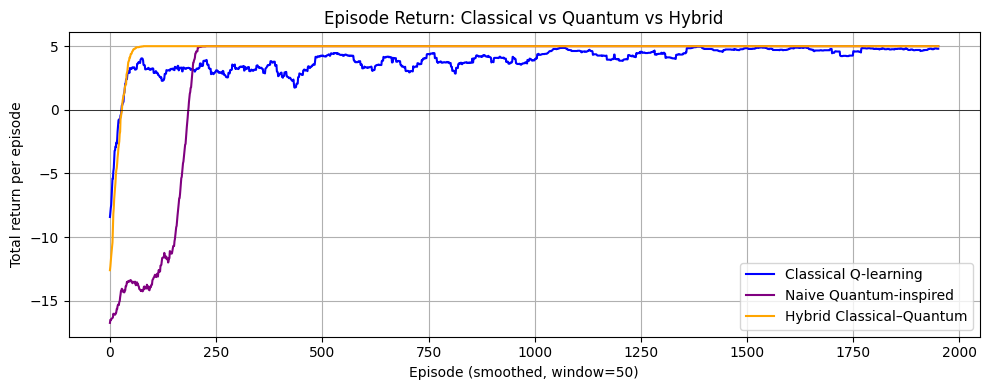

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(ma_ret_classic, label='Classical Q-learning', color='blue')
plt.plot(ma_ret_quant_naive, label='Naive Quantum-inspired', color='purple')
plt.plot(ma_ret_hybrid, label='Hybrid Classical–Quantum', color='orange')
plt.axhline(0, color='black', linewidth=0.5)
plt.xlabel('Episode (smoothed, window=50)')
plt.ylabel('Total return per episode')
plt.title('Episode Return: Classical vs Quantum vs Hybrid')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

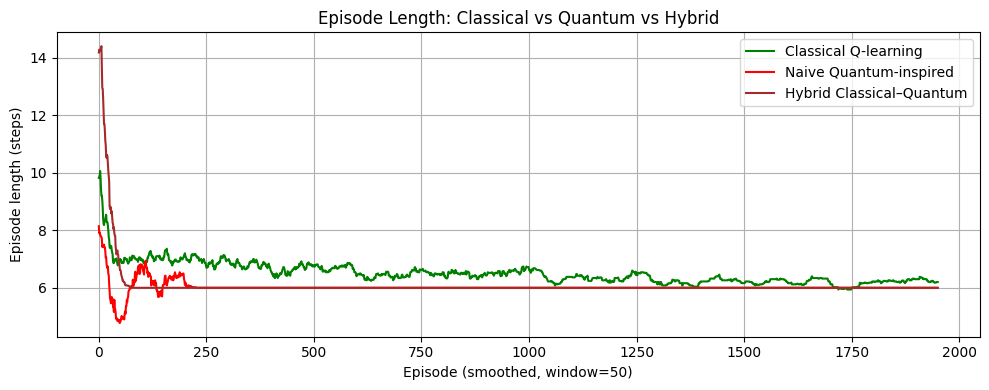

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(ma_len_classic, label='Classical Q-learning', color='green')
plt.plot(ma_len_quant_naive, label='Naive Quantum-inspired', color='red')
plt.plot(ma_len_hybrid, label='Hybrid Classical–Quantum', color='brown')
plt.xlabel('Episode (smoothed, window=50)')
plt.ylabel('Episode length (steps)')
plt.title('Episode Length: Classical vs Quantum vs Hybrid')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()